In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize, root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix

In [2]:
@jit(cache=False)
def entropy(d, beta):
    # remove 'cache=False' (only for testing)
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum < 1e-50:
        return -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        return factor * ((y * x) - (y * np.log(ysum))).sum()

In [3]:
def p_i(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    return y / ysum

In [4]:
def find_beta(d, perp, upper_bound=1e6):
    return root_scalar(
        lambda b: entropy(d, b) - np.log2(perp),
        bracket=(0.,upper_bound)
    ).root

In [59]:
def p_ij_sym(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k-1), dtype=np.int)
    p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k)
        beta = find_beta(dists[0, 1:], perp)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = p_i(dists[0, 1:], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

In [32]:
def dist_mat_squared(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

In [33]:
def norm_sym(x):
    x.fill_diagonal_(0.)
    norm_facs = x.sum(axis=0, keepdim=True)
    x = x / norm_facs
    return 0.5*(x + x.t())

In [34]:
def q_ij(x, alpha):
    dists = dist_mat_squared(x)
    q = torch.pow((1 + dists/alpha), -(alpha+1)/2)
    return norm_sym(q)

In [216]:
def kl_loss(p, q, alpha=1.0, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr.fill_diagonal_(0.)    
    return torch.sum(kl_matr)

In [205]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [221]:
class Parametric_tSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, perp,
                 alpha=1.0, hidden_layer_dims=None,
                 seed=None, use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        
        self.use_cuda = use_cuda        
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.sigmoid(layer(x))
        out = self.layers[-1](x)
        return out
        
    def fit(self, training_data, p_ij=None, epochs=10, verbose=False,
            optimizer=torch.optim.Adam, batch_size=64, learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.perplexity, verbose=verbose).toarray()
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                p = p / p.sum()
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                q = q_ij(self(features), self.alpha)
                q = q / q.sum()
                loss = kl_loss(p, q)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [96]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [97]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [218]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [245]:
foo = Parametric_tSNE(28*28, 2, 30, use_cuda=True, hidden_layer_dims=[200,200])

In [246]:
foo.fit(testdata[:10000], batch_size=500, epochs=50, learning_rate=0.01, verbose=True)

Indexing
2019-12-16 16:53:08.388282: Beginning training for 50 epochs
2019-12-16 16:53:09.006106: Loss after epoch 0: 86.4782198708488
2019-12-16 16:53:09.620462: Loss after epoch 1: 72.86752657733128
2019-12-16 16:53:10.256760: Loss after epoch 2: 67.80038229855
2019-12-16 16:53:10.884587: Loss after epoch 3: 65.24824454354014
2019-12-16 16:53:11.547814: Loss after epoch 4: 62.854051776428435
2019-12-16 16:53:12.187613: Loss after epoch 5: 62.08872466142788
2019-12-16 16:53:12.837384: Loss after epoch 6: 60.082670951788124
2019-12-16 16:53:13.481663: Loss after epoch 7: 59.3471288461019
2019-12-16 16:53:14.122947: Loss after epoch 8: 59.788495654552484
2019-12-16 16:53:14.779699: Loss after epoch 9: 58.21259914949583
2019-12-16 16:53:15.469854: Loss after epoch 10: 57.88224392048136
2019-12-16 16:53:16.110651: Loss after epoch 11: 57.865602951337614
2019-12-16 16:53:16.734980: Loss after epoch 12: 57.21383779617803
2019-12-16 16:53:17.403699: Loss after epoch 13: 56.132722879445716
20

In [247]:
bar = foo(testdata[:10000].cuda()).cpu().detach().numpy()

In [228]:
from matplotlib import pyplot as plt

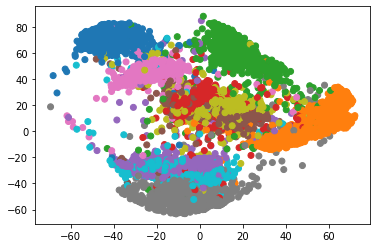

In [248]:
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:10000]]
plt.scatter(bar[:,0],bar[:,1],c=colors)